In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
import matplotlib.gridspec as gridspec

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


Num GPUs Available:  1
170500096/170498071 [==============================] - 41s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 30
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [512, 256]  # Size of the dense layers of the final classifier

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier(training=True):
    inputs = layers.Input(shape=input_shape)
    if training:
        # Augment data.
        data_augmentation = keras.Sequential(
                [
                    layers.experimental.preprocessing.Normalization(),
                    layers.experimental.preprocessing.Resizing(image_size, image_size),
                    layers.experimental.preprocessing.RandomFlip("horizontal"),
                    layers.experimental.preprocessing.RandomRotation(factor=0.02),
                    layers.experimental.preprocessing.RandomZoom(
                        height_factor=0.2, width_factor=0.2
                    ),
                ],
                name="data_augmentation",
            )
        data_augmentation.layers[0].adapt(x_train)
        preprocessed = data_augmentation(inputs)
    else:
        preproc = keras.Sequential([
            layers.experimental.preprocessing.Normalization(),
            layers.experimental.preprocessing.Resizing(image_size, image_size),
        ], name='preproc')
        preproc.layers[0].adapt(x_train)
        preprocessed = preproc(inputs)
    # Create patches.
    patches = Patches(patch_size)(preprocessed)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    attention_scores = []
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output, attention_score = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1, return_attention_scores=True)
        attention_scores.append(attention_score)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=[logits, attention_scores])
    return model

In [4]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss={'logits': keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/30
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
704/704 [==============================] - 159s 215ms/step - loss: 2.0486 - dense_19_loss: 2.0486 - val_loss: 1.6901 - val_dense_19_loss: 1.6901
Epoch 2/30
704/704 [==============================] - 151s 214ms/step - loss: 1.6861 - dense_19_loss: 1.6861 - val_loss: 1.3992 - val_dense_19_loss: 1.3992
Epoch 3/30
704/704 [==============================] - 149s 212ms/step - loss: 1.5012 - dense_19_loss: 1.5012 - val_loss: 1.2171 - val_dense_19_loss: 1.2171
Epoch 4/30
704/704 [==============================] - 149s 212ms/step - loss: 1.3613 - dense_19_loss: 1.3613 - val_loss: 1.1603 - val_dense_19_loss: 1.1603
Epoch 5/30
704/704 [==============================] - 149s 212ms/step - loss: 1.2646 - dense_19_loss: 1.2646 - val_loss: 1.0491 - val_dense_19_loss: 1.0491
Epoch 6/30
704/704 [==============================] - 149s 212ms/step - loss: 1.20

In [5]:
def attention_rolout(att_mat, add_residual=True):
    if add_residual:
        eye = np.eye(att_mat.shape[1])
        residual_corrected_att = att_mat + eye
        residual_corrected_att = residual_corrected_att / residual_corrected_att.sum(axis=1)[...,None]
        residual_corrected_att = np.flip(residual_corrected_att, 0)
    else:
        residual_corrected_att = np.flip(att_mat, 0)
    
    joint_attentions = np.zeros(residual_corrected_att.shape)
    
    layers = joint_attentions.shape[0]
    joint_attentions[0] = residual_corrected_att[0]
    for i in np.arange(1,layers):
        joint_attentions[i] = residual_corrected_att[i].dot(joint_attentions[i-1])
        
    return joint_attentions

def plot_attention_rollout(att_mat):
    img = att_mat[-1].sum(axis=1).reshape(12,12)
    plt.imshow(img)
    plt.show()

def attention_overlay(att_mat, img, alpha=0.4, plot_size=(32,32)):
    img = cv2.resize(img, dsize=plot_size, interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(att_mat[-1].sum(axis=0).reshape(12,12),
                      dsize=plot_size, interpolation=cv2.INTER_NEAREST)
    
    dif, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
    
    ax1.imshow(img)
    ax2.imshow(img)
    ax2.imshow(mask, alpha=alpha)
    ax3.imshow(mask)
    plt.show()

In [6]:
vit_classifier.save_weights('viz.weights')

In [6]:
viz = create_vit_classifier(training=False)
viz.load_weights('viz.weights')

7 [7]


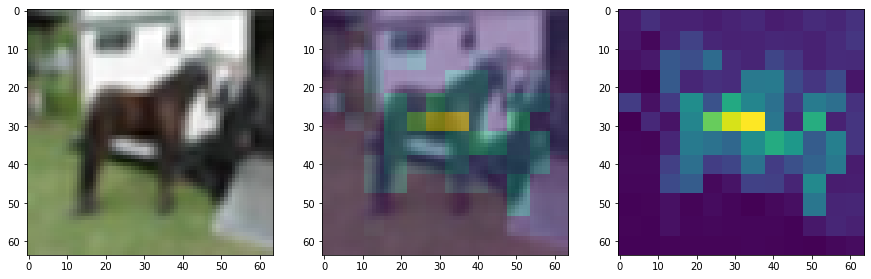

In [26]:
idx = 20 # 15 10 50
#plt.imshow(x_test[idx])
#plt.show()
prediction, attentions = viz(x_test[idx].reshape(1,32,32,3))
attentions = np.array([_.numpy().mean(axis=1).reshape(_.shape[2:4]) for _ in attentions])
a = attention_rolout(attentions, add_residual=True)
#plot_attention_rollout(a)

print(prediction.numpy().argmax(), y_test[idx])
attention_overlay(a, x_test[idx], alpha=0.5, plot_size=(64,64))

9 [9]


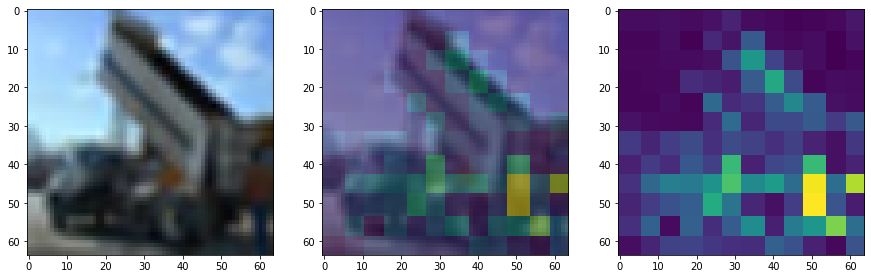

In [27]:
idx = 50
#plt.imshow(x_test[idx])
#plt.show()
prediction, attentions = viz(x_test[idx].reshape(1,32,32,3))
attentions = np.array([_.numpy().mean(axis=1).reshape(_.shape[2:4]) for _ in attentions])
a = attention_rolout(attentions, add_residual=True)
#plot_attention_rollout(a)

print(prediction.numpy().argmax(), y_test[idx])
attention_overlay(a, x_test[idx], alpha=0.5, plot_size=(64,64))

0 [0]


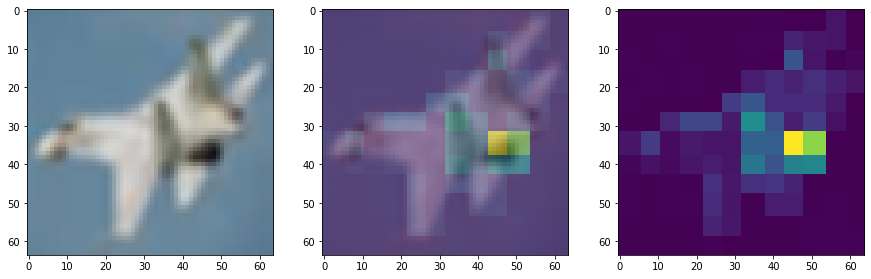

In [28]:
idx = 10
#plt.imshow(x_test[idx])
#plt.show()
prediction, attentions = viz(x_test[idx].reshape(1,32,32,3))
attentions = np.array([_.numpy().mean(axis=1).reshape(_.shape[2:4]) for _ in attentions])
a = attention_rolout(attentions, add_residual=True)
#plot_attention_rollout(a)

print(prediction.numpy().argmax(), y_test[idx])
attention_overlay(a, x_test[idx], alpha=0.5, plot_size=(64,64))

2 [2]


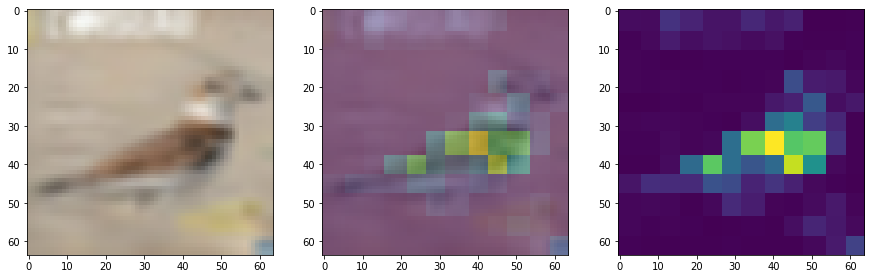

In [29]:
idx = 70 # 15 10 50
#plt.imshow(x_test[idx])
#plt.show()
prediction, attentions = viz(x_test[idx].reshape(1,32,32,3))
attentions = np.array([_.numpy().mean(axis=1).reshape(_.shape[2:4]) for _ in attentions])
a = attention_rolout(attentions, add_residual=True)
#plot_attention_rollout(a)

print(prediction.numpy().argmax(), y_test[idx])
attention_overlay(a, x_test[idx], alpha=0.5, plot_size=(64,64))

1 [1]


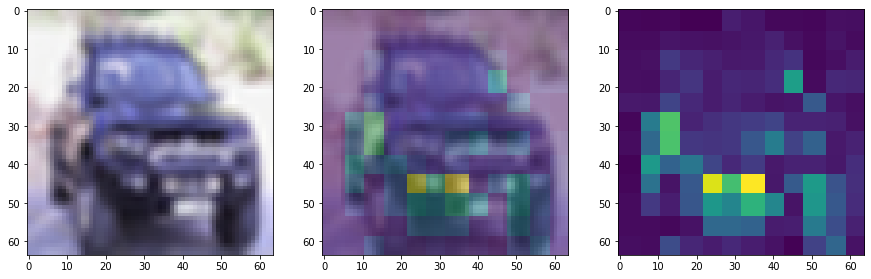

In [34]:
idx = 9 # 15 10 50
#plt.imshow(x_test[idx])
#plt.show()
prediction, attentions = viz(x_test[idx].reshape(1,32,32,3))
attentions = np.array([_.numpy().mean(axis=1).reshape(_.shape[2:4]) for _ in attentions])
a = attention_rolout(attentions, add_residual=True)
#plot_attention_rollout(a)

print(prediction.numpy().argmax(), y_test[idx])
attention_overlay(a, x_test[idx], alpha=0.5, plot_size=(64,64))

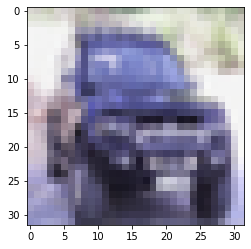

[1] 1


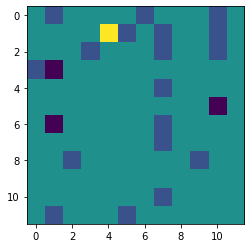

In [33]:
idx = 9
plt.imshow(x_test[idx])
plt.show()
_in = x_test[idx].reshape(1,32,32,3)
prediction, attentions = viz(_in)
print(y_test[idx], np.argmax(prediction.numpy()))
plot_attention_rollout(attentions[0].numpy().mean(axis=1))

In [7]:
viz.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
preproc (Sequential)            (None, 72, 72, 3)    7           input_1[0][0]                    
__________________________________________________________________________________________________
patches (Patches)               (None, None, 108)    0           preproc[0][0]                    
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 144, 32)      8096        patches[0][0]                    
______________________________________________________________________________________________